<a href="https://colab.research.google.com/github/Omgandhi18/Predict-Covid-Spread/blob/main/Predict_Covid_19_Spread.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
pip install tensorflow==1.14.0

     |████████████████████████████████| 109.3MB 36kB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 3.2MB 30.8MB/s 
     |████████████████████████████████| 491kB 38.6MB/s 
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.14.0 which is incompatible.
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


In [ ]:
df= pd.read_csv('covid_19_india.csv')

In [ ]:
df.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,30/01/20,6:00 PM,Kerala,1,0,0,0,1
1,2,31/01/20,6:00 PM,Kerala,1,0,0,0,1
2,3,01/02/20,6:00 PM,Kerala,2,0,0,0,2
3,4,02/02/20,6:00 PM,Kerala,3,0,0,0,3
4,5,03/02/20,6:00 PM,Kerala,3,0,0,0,3


In [ ]:
data_to_use = df['Confirmed'].values

In [ ]:
print('Total number of days in the dataset: {}'.format(len(data_to_use)))

Total number of days in the dataset: 1446


In [ ]:
scaler = StandardScaler()

In [ ]:
scaled_dataset = scaler.fit_transform(data_to_use.reshape(-1, 1))

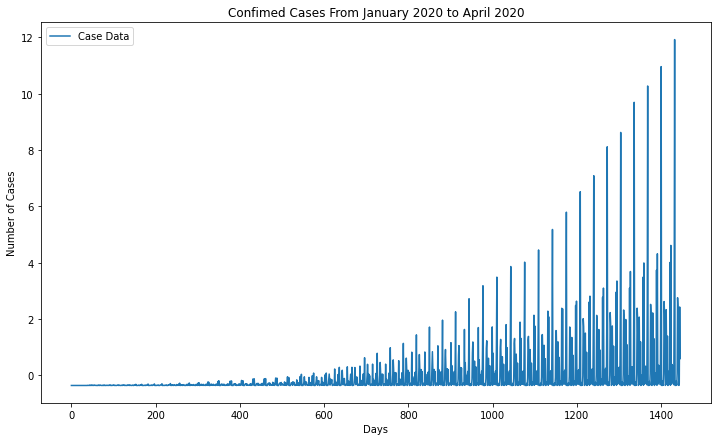

In [ ]:
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Confimed Cases From January 2020 to April 2020')
plt.xlabel('Days')
plt.ylabel('Number of Cases')
plt.plot(scaled_dataset, label='Case Data')
plt.legend()
plt.show()

In [ ]:
def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

In [ ]:
X, y = window_data(scaled_dataset, 7)

In [ ]:
X_train  = np.array(X[:1400])
y_train = np.array(y[:1400])

X_test = np.array(X[1400:])
y_test = np.array(y[1400:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1400, 7, 1)
y_train size: (1400, 1)
X_test size: (39, 7, 1)
y_test size: (39, 1)


In [ ]:
epochs =15
batch_size = 7

In [ ]:
def LSTM_cell(hidden_layer_size, batch_size,number_of_layers, dropout=True, dropout_rate=0.8):
    
    layer = tf.contrib.rnn.BasicLSTMCell(hidden_layer_size)
    
    if dropout:
        layer = tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)
        
    cell = tf.contrib.rnn.MultiRNNCell([layer]*number_of_layers)
    
    init_state = cell.zero_state(batch_size, tf.float32)
    
    return cell, init_state

In [ ]:
def output_layer(lstm_output, in_size, out_size):
    
    x = lstm_output[:, -1, :]
    print(x)
    weights = tf.Variable(tf.truncated_normal([in_size, out_size], stddev=0.05), name='output_layer_weights')
    bias = tf.Variable(tf.zeros([out_size]), name='output_layer_bias')
    
    output = tf.matmul(x, weights) + bias
    return output

In [ ]:
def opt_loss(logits, targets, learning_rate, grad_clip_margin):
    
    losses = []
    for i in range(targets.get_shape()[0]):
        losses.append([(tf.pow(logits[i] - targets[i], 2))])
        
    loss = tf.reduce_sum(losses)/(2*batch_size)
    
    #Cliping the gradient loss
    gradients = tf.gradients(loss, tf.trainable_variables())
    clipper_, _ = tf.clip_by_global_norm(gradients, grad_clip_margin)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))
    return loss, train_optimizer

In [ ]:
class CasePredictionRNN(object):
    
    def __init__(self, learning_rate=0.001, batch_size=7, hidden_layer_size=512, number_of_layers=1, 
                 dropout=True, dropout_rate=0.8, number_of_classes=1, gradient_clip_margin=4, window_size=7):
    
        self.inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1], name='input_data')
        self.targets = tf.placeholder(tf.float32, [batch_size, 1], name='targets')

        cell, init_state = LSTM_cell(hidden_layer_size, batch_size, number_of_layers, dropout, dropout_rate)

        outputs, states = tf.nn.dynamic_rnn(cell, self.inputs, initial_state=init_state)

        self.logits = output_layer(outputs, hidden_layer_size, number_of_classes)

        self.loss, self.opt = opt_loss(self.logits, self.targets, learning_rate, gradient_clip_margin)

In [ ]:
tf.reset_default_graph()
model = CasePredictionRNN()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Tensor("strided_slice:0", shape=(7, 512

In [ ]:
session =  tf.Session()

In [ ]:
session.run(tf.global_variables_initializer())

In [ ]:
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([model.logits, model.loss, model.opt], feed_dict={model.inputs:X_batch, model.targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 30) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/15  Current loss: 0.3133319914340973


In [ ]:
sup =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j])

In [ ]:
tests = []
i = 0
while i+batch_size <= len(X_test):
    
    o = session.run([model.logits], feed_dict={model.inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)

In [ ]:
tests_new = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])

In [ ]:
test_results = []
for i in range(1436):
    if i >=1401:
        test_results.append(tests_new[i-1401])
    else:
        test_results.append(None)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


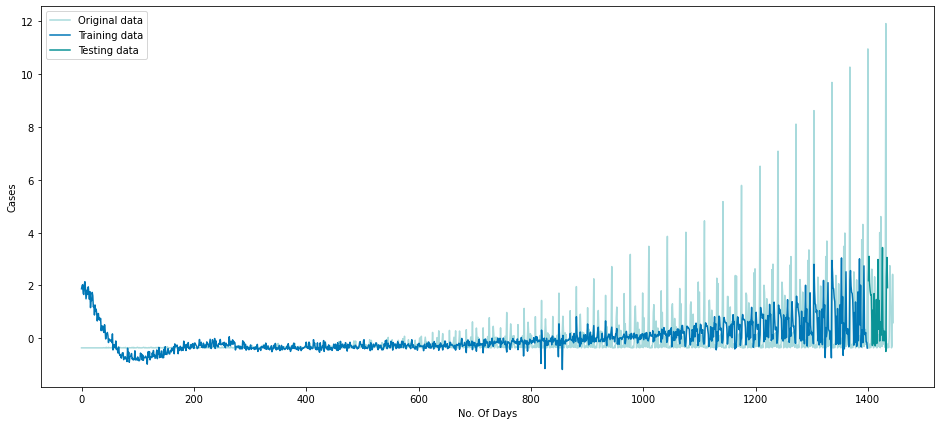

In [ ]:
plt.figure(figsize=(16, 7))
plt.plot(scaled_dataset, label='Original data',c='#a8dadc')
plt.plot(sup, label='Training data',c='#0077b6')
plt.plot(test_results, label='Testing data',c='#0a9396')
plt.xlabel('No. Of Days')
plt.ylabel('Cases')
plt.legend()
plt.show()

In [ ]:
session.close()